## Gaussian Grid

To get the parameters for the gaussian grid, it has to be visualised. The main reason for this is that $\sigma$, $\beta$, and n do not have any physical units. 

In addition to the point of interest (latitude, longitude), the following parameters have to be picked:
- $\phi_{ini}$: initial distance between grid points, in degrees
- $\phi_{max}$: maximum distance between grid points, in degrees
- $\sigma$: size of the denser part of the grid.
- $\beta$: slope of the increase in grid point distance.
- n: number of points in the variable. 
- dense antipole: Set to true if the grid should refocus at the antipole.

When a larger n is used, $\sigma$ also has to be increased. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from GaussVoronoiGrid.scripts.source_grid_gauss import gauss_grid

In [2]:
# Pick a name for the grid
grid_name = 'GaussianGrid_Example'

# Pick values for the input variables

sigma = 10
beta = 3
phi_ini = 0.5
phi_max = 3
lat_0 = 46
lon_0 = -33
n = 200
dense_antipole = False
bluemarble = False

Number of Gridpoints: 17038
Minimum dx in m: 55741.699 m which is 0.5 °
Maximum dx in m: 334450.196 m which is 3.0 °


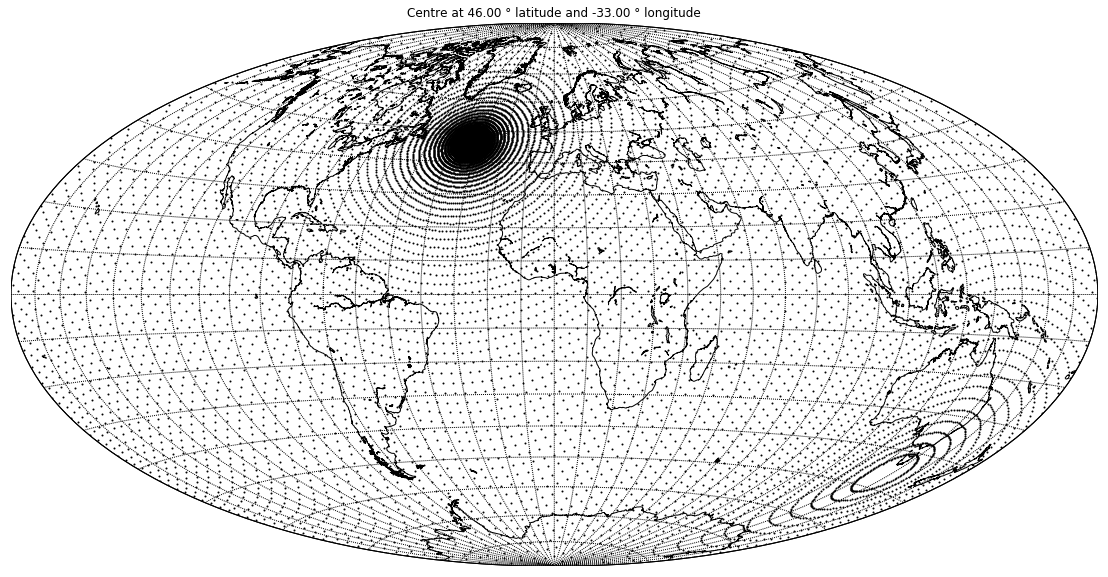

In [3]:
grid = gauss_grid(sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,plot=True,Dense_Antipole = dense_antipole, bluemarble=bluemarble)

In [4]:
# write to .npy file in grids folder
np.save(os.path.join('./grids/',grid_name),grid)
print('Sourcegrid saved as %s.npy in grids folder.' %grid_name)

Sourcegrid saved as GaussianGrid_Example.npy in grids folder.


# Voronoi Cells

After the grid is created and saved as a .npy we can compute the voronoi cells and calculate the voronoi cell surface area. As input we have the grid and as output the surface area corresponding to the voronoi cell of each grid point plus the grid, since the order might change.

In [5]:
import numpy as np
import os
import h5py
from GaussVoronoiGrid.scripts.voronoi_cells import get_voronoi_surface_area

In [6]:
## If only this is run set grid_name
# grid_name = 'GaussianGrid_Example'

# import grid from grids folder
grid = np.load(os.path.join('./grids/',grid_name + '.npy'))

In [7]:
# Set below to True if Voronoi cells are to be plotted
### NOTE: THIS TAKES A LOT LONGER
voronoi_plot = False

# calculate voronoi surface area
grd, voronoi_areas = get_voronoi_surface_area(grid,voronoi_plot=voronoi_plot)

0 of 17038 voronoi cell surface areas calculated.
1000 of 17038 voronoi cell surface areas calculated.
2000 of 17038 voronoi cell surface areas calculated.
3000 of 17038 voronoi cell surface areas calculated.
4000 of 17038 voronoi cell surface areas calculated.
5000 of 17038 voronoi cell surface areas calculated.
6000 of 17038 voronoi cell surface areas calculated.
7000 of 17038 voronoi cell surface areas calculated.
8000 of 17038 voronoi cell surface areas calculated.
9000 of 17038 voronoi cell surface areas calculated.
10000 of 17038 voronoi cell surface areas calculated.
11000 of 17038 voronoi cell surface areas calculated.
12000 of 17038 voronoi cell surface areas calculated.
13000 of 17038 voronoi cell surface areas calculated.
14000 of 17038 voronoi cell surface areas calculated.
15000 of 17038 voronoi cell surface areas calculated.
16000 of 17038 voronoi cell surface areas calculated.
17000 of 17038 voronoi cell surface areas calculated.
All voronoi cell surface areas calculated

In [8]:
# Save grid and voronoi cell areas to .h5 file
with h5py.File(os.path.join('./grids/',grid_name + '.h5'),'w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('voronoi_areas',data=voronoi_areas.astype(np.float32))

## Only Ocean

The below code can be run if the grid is only needed in the ocean. This has to be done after the Voronoi cells are calculated since the voronoi cells of the gridpoints on the sea shore would otherwise have too much weight. 

In [9]:
from GaussVoronoiGrid.scripts.voronoi_cells import get_ocean_mask
import numpy as np
import os
import h5py

In [10]:
# Load grid and voronoi cell area from .h5 file
grid = h5py.File(os.path.join('./grids/',grid_name + '.h5'),'r')

grid_coordinates = np.array(grid.get('coordinates'))
grid_voronoi_areas = np.array(grid.get('voronoi_areas'))

In [11]:
# Get the ocean mask
ocean_mask = get_ocean_mask(grid_coordinates)

Getting ocean mask...
Latitudes: -89.38999938964844 to 88.91999816894531, Longitudes: -179.9600067138672 to 179.80999755859375
Getting ocean mask done.


In [12]:
# Get rid of all points and voronoi cells on land

grid_onlyocean_lon = []
grid_onlyocean_lat = []
voronoi_areas_onlyocean = []

for i in range(0,np.size(ocean_mask)):
    if ocean_mask[i]:
        grid_onlyocean_lon.append(grid_coordinates[0][i])
        grid_onlyocean_lat.append(grid_coordinates[1][i])
        voronoi_areas_onlyocean.append(voronoi_areas[i])
    else:
        continue
        
grid_onlyocean = np.asarray([grid_onlyocean_lon,grid_onlyocean_lat])
voronoi_areas_onlyocean = np.asarray(voronoi_areas_onlyocean)

In [13]:
# write to knew .h5 file
with h5py.File(os.path.join('./grids/',grid_name + '_onlyocean.h5'),'w') as fh:
    fh.create_dataset('coordinates',data=grid_onlyocean.astype(np.float32))
    fh.create_dataset('voronoi_areas',data=voronoi_areas_onlyocean.astype(np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


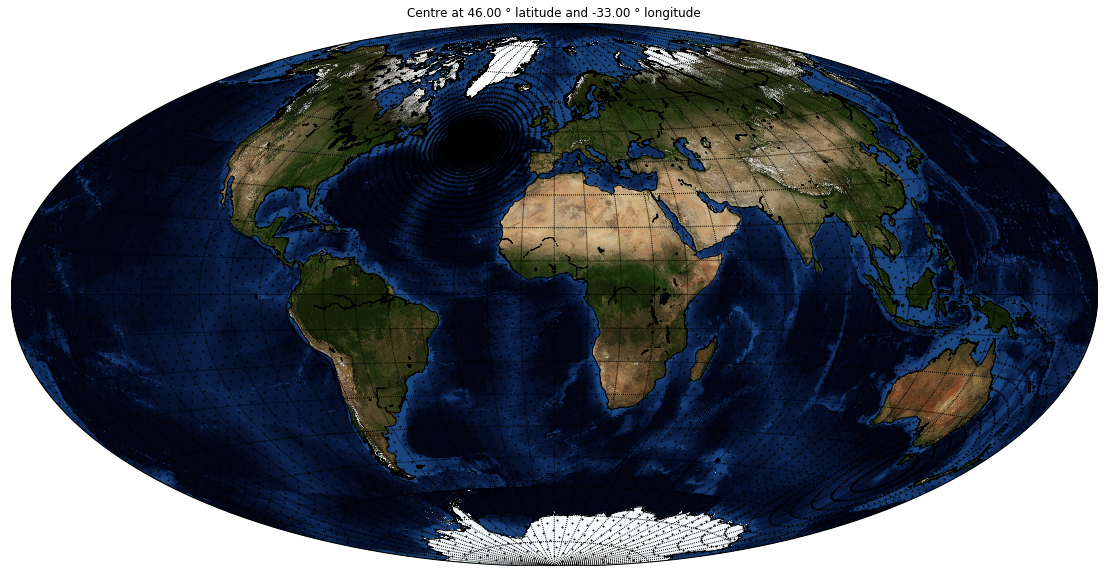

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(25,10))
map = Basemap(projection='hammer',lat_0=0,lon_0=0,resolution='l')
map.drawcoastlines()
#map.drawcountries()
#map.fillcontinents(color = 'coral',lake_color='aqua')
#map.drawmapboundary()
map.bluemarble()
parallels = np.arange(-90.,90,10.)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[False,False,False,False])
meridians = np.arange(0.,360.,10.)
map.drawmeridians(meridians,labels=[False,False,False,False])
x,y = map(grid_onlyocean_lon, grid_onlyocean_lat)
map.plot(x, y,'ko', markersize=1)

plt.title('Centre at %0.2f ° latitude and %0.2f ° longitude' %(lat_0,lon_0))
plt.show()